# **BirdCLEF 2025 Data Preprocessing Notebook**

In [1]:
import os
import cv2
import math
import time
import librosa
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import noisereduce as nr
import os
import numpy as np
from datetime import datetime
import pytz
import torch
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import StratifiedGroupKFold

from joblib import Parallel, delayed


from module import config_lib, utils_lib

In [2]:
class DatasetConfig:
    def __init__(self, kaggle_notebook=False, debug=False):
        self.KAGGLE_NOTEBOOK = kaggle_notebook
        self.debug = debug

        # ===== Path Settings =====
        if self.KAGGLE_NOTEBOOK:
            self.OUTPUT_DIR = ''
            self.PROCESSED_DIR = ""
            self.train_datadir = '/kaggle/input/birdclef-2025/train_audio'
            self.train_csv = '/kaggle/input/birdclef-2025/train.csv'
            self.test_soundscapes = '/kaggle/input/birdclef-2025/test_soundscapes'
            self.submission_csv = '/kaggle/input/birdclef-2025/sample_submission.csv'
            self.taxonomy_csv = '/kaggle/input/birdclef-2025/taxonomy.csv'
            self.model_path = '/kaggle/input/birdclef-2025-0330'
        else:
            self.OUTPUT_DIR = '../data/result/'
            self.train_datadir = '../data/raw/train_audio/'
            self.train_csv = '../data/raw/train.csv'
            self.test_soundscapes = '../data/raw/test_soundscapes/'
            self.submission_csv = '../data/raw/sample_submission.csv'
            self.taxonomy_csv = '../data/raw/taxonomy.csv'
            self.models_dir = "../models/" # 全modelの保存先
            self.model_path = self.models_dir # 各モデルの保存先．学習時に動的に変更．
            self.RAW_DIR = '../data/raw/'
            self.PROCESSED_DIR = '../data/processed/'


        # ===== Audio Settings =====
        self.FS = 32000
        self.WINDOW_SIZE = 5.0 # 推論時のウィンドウサイズ
        self.TARGET_DURATION = 5 # データセット作成時のウィンドウサイズ
        self.TARGET_SHAPE = (256, 256)
        self.N_FFT = 1024
        self.HOP_LENGTH = 16
        self.N_MELS = 148
        self.FMIN = 20
        self.FMAX = 16000
        self.N_MAX = 50 if self.debug else None        
        self.N_JOBS = 16  # 並列処理のスレッド数 16くらいでいい
        self.N_JOBS_DURATION = 47 # duration計算の際のスレッド数
        self.LOAD_ENGINE = 'torchaudio'  # librosa or torchaudio
        self.SKIP_RESIZE = False  # resizeしないならTrue
        self.seed = 42
        self.n_fold = 5
        self.num_rare_samples = 50 # これ以下のサンプル数のspeciesはrare speciesとして扱う
        self.is_crop_aug = False
        
        # denoising factor
        self.prop_decrease=0.8
        
        

In [3]:
config = DatasetConfig(kaggle_notebook=False, debug=False)

In [4]:
utils_lib.set_seed(config.seed)

In [5]:
print(f"Debug mode: {'ON' if config.debug else 'OFF'}")
print(f"Max samples to process: {config.N_MAX if config.N_MAX is not None else 'ALL'}")

print("Loading taxonomy data...")
taxonomy_df = pd.read_csv(f'{config.RAW_DIR}/taxonomy.csv')
species_class_map = dict(zip(taxonomy_df['primary_label'], taxonomy_df['class_name']))

print("Loading training metadata...")
train_df = pd.read_csv(f'{config.RAW_DIR}/train.csv')

Debug mode: OFF
Max samples to process: ALL
Loading taxonomy data...
Loading training metadata...


In [6]:
label_list = sorted(train_df['primary_label'].unique())
label_id_list = list(range(len(label_list)))
label2id = dict(zip(label_list, label_id_list))
id2label = dict(zip(label_id_list, label_list))

print(f'Found {len(label_list)} unique species')
working_df = train_df.copy()
working_df['target'] = working_df.primary_label.map(label2id)
working_df['filepath'] = config.RAW_DIR + '/train_audio/' + working_df.filename
working_df['samplename'] = working_df.filename.map(lambda x: x.split('/')[0] + '-' + x.split('/')[-1].split('.')[0])
working_df['class'] = working_df.primary_label.map(lambda x: species_class_map.get(x, 'Unknown'))
working_df["crop_strategy"] = "center"
total_samples = min(len(working_df), config.N_MAX or len(working_df))
print(f'Total samples to process: {total_samples} out of {len(working_df)} available')
print(f'Samples by class:')
print(working_df['class'].value_counts())

Found 206 unique species
Total samples to process: 28564 out of 28564 available
Samples by class:
class
Aves        27648
Amphibia      583
Mammalia      178
Insecta       155
Name: count, dtype: int64


In [7]:
# 全音源の長さを計算
def get_duration(filepath, sr):
    try:
        audio, _ = librosa.load(filepath, sr=sr)
        return len(audio) / sr
    except Exception as e:
        print(f"[ERROR] Could not load {filepath}: {e}")
        return np.nan

print("🔄 Calculating durations with parallel processing...")

# tqdm 対応
filepaths = working_df['filepath'].tolist()
durations = Parallel(n_jobs=config.N_JOBS_DURATION)(
    delayed(get_duration)(fp, config.FS) for fp in tqdm(filepaths)
)

working_df['duration_sec'] = durations
print("✅ Added 'duration_sec' column to working_df")

🔄 Calculating durations with parallel processing...


  0%|          | 0/28564 [00:00<?, ?it/s]

✅ Added 'duration_sec' column to working_df


In [8]:
# 音源の使える範囲を制限．

# 1. 列を初期化
working_df["valid_start_sec"] = 0
working_df["valid_end_sec"] = None  # None or np.nan にしておく


# CSA コレクションの音源 → 後ろ7秒を無効に．スペイン語の除去
csa_mask = working_df['collection'] == 'CSA'
working_df.loc[csa_mask, 'valid_end_sec'] = working_df.loc[csa_mask, 'duration_sec'] - 7.0

# 負の値にならないように
working_df['valid_end_sec'] = working_df['valid_end_sec'].clip(lower=0.0)

# 3. 例外的に full duration を許可するラベル・ファイル
# 理由: CSAだがスペイン語解説がない
# ✅ 例外ラベル（primary_labelベース）
exception_labels = ['1564122', '523060', '548639', '714022', '868458']

# ✅ 例外ファイル（filenameベース）
exception_filenames = [
    '50186/CSA28885.ogg',
    '52884/CSA14875.ogg'
]

working_df.loc[working_df['primary_label'].isin(exception_labels), 'valid_end_sec'] = None
working_df.loc[working_df['filename'].isin(exception_filenames), 'valid_end_sec'] = None


# 4. 特定のファイルの valid_start_sec を変更
# 特定のファイル（最初にスペイン語が含まれる）
spanish_intro_filenames = [
    '50186/CSA28885.ogg',
    '52884/CSA14875.ogg'
]
# valid_start_sec を 4.0 に変更
working_df.loc[
    working_df['filename'].isin(spanish_intro_filenames),
    'valid_start_sec'
] = 4.0


# 途中で人の声のみになるので除去
voice_only_ranges = {
    '476537/CSA35459.ogg': 134,  # 2分14秒 = 134秒
    '476537/CSA35461.ogg': 259,  # 4分19秒 = 259秒
}
for fname, end_sec in voice_only_ranges.items():
    working_df.loc[
        working_df['filename'] == fname,
        'valid_end_sec'
    ] = end_sec


# Eliana Barona- Cortés　の音源．話している部分．いらない部分
# 24292/CSA34649.ogg 2min8以降
# 24292/CSA34651.ogg 1min33以降
# 50186/CSA34622.ogg 21s以降
# 50186/CSA34678.ogg 43s以降
voice_only_ranges = {
    '24292/CSA34649.ogg': 128,   # 2分8秒 = 128秒
    '24292/CSA34651.ogg': 93,    # 1分33秒 = 93秒
    '50186/CSA34622.ogg': 21,    # 21秒
    '50186/CSA34678.ogg': 43,    # 43秒
}
for fname, end_sec in voice_only_ranges.items():
    working_df.loc[
        working_df['filename'] == fname,
        'valid_end_sec'
    ] = end_sec

# Alexandra Butrago-Cardona の音源チェック
# 話している部分．いらない部分
# 24292/CSA35021.ogg 36s以降
# 52884/CSA34947.ogg 13s以降
voice_only_ranges = {
    '24292/CSA35021.ogg': 36,    # 36秒
    '52884/CSA34947.ogg': 13,     # 13秒
}
for fname, end_sec in voice_only_ranges.items():
    working_df.loc[
        working_df['filename'] == fname,
        'valid_end_sec'
    ] = end_sec


# Fabio A. Sarria-S の音声は 0〜7秒 だけ使用可能に設定．後半はただの説明なので
fabio_filenames = train_df.loc[
    train_df['author'] == "Fabio A. Sarria-S", 'filename'
].tolist()
# 
working_df.loc[
    working_df['filename'].isin(fabio_filenames), 'valid_end_sec'
] = 7.0

#  Fabioの解説で，必ずしも7secではないもの
fabio_override = {
    "48124/CSA36346.ogg": 24.0,
    "52884/CSA36344.ogg": 55.0,
    "52884/CSA36342.ogg": 14.0,  # ← 追加分
}

for fname, end_sec in fabio_override.items():
    working_df.loc[
        working_df['filename'] == fname,
        'valid_end_sec'
    ] = end_sec


# valid_end_sec が None なら duration_sec に補完
working_df['valid_end_sec'] = working_df.apply(
    lambda row: row['duration_sec'] if pd.isna(row['valid_end_sec']) else row['valid_end_sec'],
    axis=1
)
# valid_start_sec が None なら 0 に補完（念のため）
working_df['valid_start_sec'] = working_df['valid_start_sec'].fillna(0)


In [9]:
# crop戦略

# crop戦略は基本center
working_df["crop_strategy"] = "center"

# # 1. duration_sec が 5秒未満のものは head crop
# short_duration_mask = (
#     (working_df['valid_end_sec'] - working_df['valid_start_sec']) < config.TARGET_DURATION
# )
# working_df.loc[short_duration_mask, "crop_strategy"] = "head"

In [10]:
# 除去するファイルを指定
working_df["is_valid_audio"] = True


# # === 2. 除去対象ファイルを False に上書き ===
# fabio_remove_filenames = [
#     '1139490/CSA36385.ogg',
#     '1462737/CSA36369.ogg',
#     '1462737/CSA36380.ogg',
#     '1462737/CSA36381.ogg',
#     '1462737/CSA36386.ogg',
#     '1462737/CSA36391.ogg',
#     '1462737/CSA36395.ogg',
#     '963335/CSA36374.ogg',
#     '963335/CSA36375.ogg',
# ]
# working_df.loc[working_df["filename"].isin(fabio_remove_filenames), "is_valid_audio"] = False

# ノイズ除去するファイルを指定
working_df["apply_denoise"] = False

# fabio_denoise_filenames = [
#     '1462711/CSA36371.ogg',
#     '1462711/CSA36379.ogg',
#     '963335/CSA36372.ogg',
#     '963335/CSA36377.ogg',
# ]

# working_df.loc[working_df["filename"].isin(fabio_denoise_filenames), "apply_denoise"] = True

In [11]:
# augmentationのための処理．各音源でどれくらい増やすのかを事前に決定

# 初期化
working_df['n_augment'] = 0
working_df['multi_crop'] = False

target_samples = int(config.TARGET_DURATION * config.FS)



# rareなラベルを抽出
label_counts = working_df['primary_label'].value_counts().rename_axis("label").reset_index(name="sample_count")
rare_labels = label_counts[label_counts['sample_count'] < config.num_rare_samples]['label'].tolist()

# ✅ rare種ごとに crop 数を割り当てる
for rare_label in rare_labels:
    base_rows = working_df[working_df['primary_label'] == rare_label]
    n_exist = len(base_rows)
    n_needed = config.num_rare_samples - n_exist
    n_aug_per_sample = math.ceil(n_needed / n_exist)

    for idx, row in base_rows.iterrows():
        usable_duration_sec = row['valid_end_sec'] - row['valid_start_sec']
        usable_samples = int(usable_duration_sec * config.FS)

        # 少なくとも2倍にする
        max_possible = usable_samples // target_samples
        n_actual = min(n_aug_per_sample, max_possible)

        if n_actual > 0:
            working_df.at[idx, 'multi_crop'] = True
            working_df.at[idx, 'n_augment'] = n_actual
            
            
if not config.is_crop_aug:
    working_df['n_augment'] = 0
    working_df['multi_crop'] = False

# num_augmented
print(f"Total number of augmentations: {working_df['n_augment'].sum()}")

Total number of augmentations: 0


In [12]:
# crop_strategyに基づいて音声データを切り出す
def crop_audio(audio_data: np.ndarray, target_samples: int, strategy='center'):
    total_samples = len(audio_data)

    if total_samples < target_samples:
        n_copy = math.ceil(target_samples / total_samples)
        audio_data = np.concatenate([audio_data] * n_copy)
        total_samples = len(audio_data)

    if strategy == 'head':
        start_idx = 0
    elif strategy == 'tail':
        start_idx = total_samples - target_samples
    elif strategy == 'center':
        start_idx = total_samples // 2 - target_samples // 2
    elif strategy == 'random':
        max_start = total_samples - target_samples
        start_idx = np.random.randint(0, max_start + 1)
    elif isinstance(strategy, (float, int)):
        start_idx = int(strategy * config.FS)
    else:
        raise ValueError(f"Unknown strategy: {strategy}")

    start_idx = max(0, min(start_idx, total_samples - target_samples))
    end_idx = start_idx + target_samples
    return audio_data[start_idx:end_idx]

In [13]:
# audioをmelに変換
def audio2melspec(audio_data):
    if np.isnan(audio_data).any():
        mean_signal = np.nanmean(audio_data)
        audio_data = np.nan_to_num(audio_data, nan=mean_signal)

    mel_spec = librosa.feature.melspectrogram(
        y=audio_data,
        sr=config.FS,
        n_fft=config.N_FFT,
        hop_length=config.HOP_LENGTH,
        n_mels=config.N_MELS,
        fmin=config.FMIN,
        fmax=config.FMAX,
        power=2.0
    )

    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min() + 1e-8)
    
    return mel_spec_norm

In [14]:
# 音源をmelに変える処理．並列化に対応
def process_row(row):
    try:
        audio_data, _ = librosa.load(row.filepath, sr=config.FS)
        target_samples = int(config.TARGET_DURATION * config.FS)

        mel_list = []
        name_list = []
        
        # ✅ 必要ならノイズ除去
        if row.get("apply_denoise", False):
            audio_data = nr.reduce_noise(y=audio_data, sr=config.FS, prop_decrease=config.prop_decrease)

        # === 有効範囲を秒 → サンプルに変換 ===
        valid_start_sec = row.get("valid_start_sec", 0)
        valid_end_sec = row.get("valid_end_sec", None)
        duration_sec = len(audio_data) / config.FS

        if pd.isna(valid_end_sec) or valid_end_sec is None:
            valid_end_sec = duration_sec

        valid_start_sample = int(valid_start_sec * config.FS)
        valid_end_sample = int(valid_end_sec * config.FS)

        usable_audio = audio_data[valid_start_sample:valid_end_sample]
        total_usable_samples = len(usable_audio)

        # === オリジナル clip ===
        strategy = row.crop_strategy
        try:
            strategy = float(strategy)  # 数値指定の場合にも対応
        except ValueError:
            pass

        clip = crop_audio(usable_audio, target_samples, strategy=strategy)
        if len(clip) < target_samples:
            clip = np.pad(clip, (0, target_samples - len(clip)), mode='constant')
        mel = audio2melspec(clip)
        if mel.shape != config.TARGET_SHAPE:
            mel = cv2.resize(mel, config.TARGET_SHAPE, interpolation=cv2.INTER_LINEAR)
        mel_list.append(mel.astype(np.float32))
        name_list.append(row.samplename)

        # === n_augment に応じて crop ===
        n_aug = int(row.get("n_augment", 0))
        if n_aug <= 0:
            return list(zip(name_list, mel_list)), None

        interval = max((total_usable_samples - target_samples) // (n_aug + 1), 1)

        for i in range(n_aug):
            start_idx = min(i * interval, total_usable_samples - target_samples)
            clip = usable_audio[start_idx: start_idx + target_samples]
            if len(clip) < target_samples:
                clip = np.pad(clip, (0, target_samples - len(clip)), mode='constant')
            mel_crop = audio2melspec(clip)
            if mel_crop.shape != config.TARGET_SHAPE:
                mel_crop = cv2.resize(mel_crop, config.TARGET_SHAPE, interpolation=cv2.INTER_LINEAR)
            mel_list.append(mel_crop.astype(np.float32))
            name_list.append(f"{row.samplename}_crop{i}")

        return list(zip(name_list, mel_list)), None

    except Exception as e:
        return None, (row.filepath, str(e))

In [15]:
# mel変換を並列化
results = Parallel(n_jobs=config.N_JOBS)(
    delayed(process_row)(row) for _, row in working_df.iloc[:total_samples].iterrows()
)

# 結果の整理
all_bird_data = {}
errors = []

for result, err in results:
    if result is not None:
        for name, mel in result:
            all_bird_data[name] = mel
    if err is not None:
        errors.append(err)
        
print(f"Total errors: {len(errors)}")
if errors:
    print("Errors:")
    for filepath, error in errors:
        print(f"  {filepath}: {error}")    

Total errors: 0


In [16]:
# working_dfにaugmentしたデータ情報を追加
augmented_rows = []

for _, row in working_df.iterrows():
    n_aug = int(row.get('n_augment', 0))
    if n_aug > 0:
        for i in range(n_aug):
            new_row = row.copy()
            new_row['samplename'] = f"{row.samplename}_crop{i}"
            augmented_rows.append(new_row)

# DataFrameにまとめる
augmented_rows = pd.DataFrame(augmented_rows)
working_df_augmented = pd.concat([working_df, augmented_rows], ignore_index=True)
print(f"✅ working_df_augmented created with {len(augmented_rows)} augmented rows.")

✅ working_df_augmented created with 0 augmented rows.


In [17]:
# 事前にfoldを決めておく．5fold．


working_df_augmented['group_id'] = working_df_augmented['samplename'].map(lambda x: x.split('_crop')[0])

# fold 列を初期化
working_df_augmented['fold'] = -1

# ✅ stratify + group 両立！
sgkf = StratifiedGroupKFold(n_splits=config.n_fold, shuffle=True, random_state=config.seed)
groups = working_df_augmented['group_id']
labels = working_df_augmented['primary_label']

for fold_id, (_, val_idx) in enumerate(sgkf.split(working_df_augmented, labels, groups=groups)):
    working_df_augmented.loc[val_idx, 'fold'] = fold_id

In [18]:
# === 無効な音源を除外（fold付与後） ===
working_df_filtered = working_df_augmented[working_df_augmented["is_valid_audio"]].reset_index(drop=True)

print(f"📉 Removed {len(working_df_augmented) - len(working_df_filtered)} rows marked as invalid audio.")
print(f"✅ Final training set size: {len(working_df_filtered)}")

working_df_augmented = working_df_filtered.copy()

📉 Removed 0 rows marked as invalid audio.
✅ Final training set size: 28564


In [19]:
# melとworking_dfを保存．working_dfはtrain.csvとして保存

# 4mins
import os
import numpy as np
import pickle
import csv
from datetime import datetime
import pytz

# === JST時刻でディレクトリ作成 ===
jst = pytz.timezone('Asia/Tokyo')
now = datetime.now(jst)
timestamp = now.strftime("%Y%m%d_%H%M")

# ✅ 保存先フォルダを debug に応じて分岐
if config.debug:
    output_dir = os.path.join(config.PROCESSED_DIR, "data_debugs")
else:
    output_dir = os.path.join(config.PROCESSED_DIR, f"melspec_{timestamp}")
os.makedirs(output_dir, exist_ok=True)

# === 1. melスペクトログラムの保存 ===
output_path = os.path.join(output_dir, "birdclef2025_melspec_5sec_256_256.npy")
wrapped_array = np.array(all_bird_data, dtype=object)

with open(output_path, 'wb') as f:
    pickle.dump(wrapped_array, f, protocol=5)

print(f"\n✅ Mel-spectrograms saved to: {output_path}")
print(f"📦 File size: {os.path.getsize(output_path) / (1024 ** 2):.2f} MB")
print(f"📐 Example shape: {next(iter(all_bird_data.values())).shape}")

# === 2. configの保存 ===
config_path = os.path.join(output_dir, "config.csv")
config_dict = {k: v for k, v in vars(config).items() if not k.startswith("__")}

with open(config_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["key", "value"])
    for key, value in config_dict.items():
        writer.writerow([key, value])

print(f"📝 Config saved to: {config_path}")


# ✅ train.csv として保存
train_csv_path = os.path.join(output_dir, "train.csv")
working_df_augmented.to_csv(train_csv_path, index=False)

print(f"📝 Augmented training metadata saved to: {train_csv_path}")
print(f"📊 Total rows: {len(working_df_augmented)}")


✅ Mel-spectrograms saved to: ../data/processed/melspec_20250419_1324/birdclef2025_melspec_5sec_256_256.npy
📦 File size: 7143.48 MB
📐 Example shape: (256, 256)
📝 Config saved to: ../data/processed/melspec_20250419_1324/config.csv
📝 Augmented training metadata saved to: ../data/processed/melspec_20250419_1324/train.csv
📊 Total rows: 28564


In [267]:
from importlib import reload
reload(utils_lib)

<module 'module.utils_lib' from '/root/program/birdclef-2025/scripts/module/utils_lib.py'>

In [229]:
# ゼロだけじゃなく、"ほぼゼロ"の小さな値も対象に
def fill_mel_gaps_both_threshold(mel, threshold=0.01):
    mel = mel.copy()

    # 時間方向
    for f in range(mel.shape[0]):
        row = mel[f]
        mask = row < threshold
        if mask.any():
            valid_idx = np.where(~mask)[0]
            if len(valid_idx) >= 2:
                mel[f, mask] = np.interp(np.where(mask)[0], valid_idx, row[valid_idx])

    # 周波数方向
    for t in range(mel.shape[1]):
        col = mel[:, t]
        mask = col < threshold
        if mask.any():
            valid_idx = np.where(~mask)[0]
            if len(valid_idx) >= 2:
                mel[mask, t] = np.interp(np.where(mask)[0], valid_idx, col[valid_idx])

    return mel

filename="banana-XC561261"
mel = all_bird_data[filename]

filled_mel = fill_mel_gaps_both_threshold(mel, threshold=0.1)
mels = {filename: filled_mel}

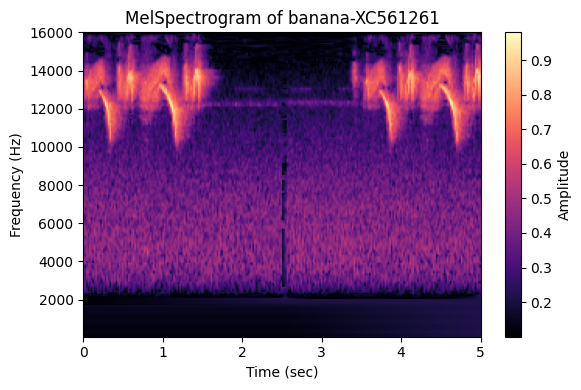

In [230]:
utils_lib.plot_melspectrogram(mels, "banana-XC561261")
utils_lib.play_audio("banana/XC561261.ogg", config.train_datadir)

In [269]:
working_df_augmented[working_df_augmented["apply_denoise"] == True]

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,...,crop_strategy,duration_sec,valid_start_sec,valid_end_sec,is_valid_audio,apply_denoise,n_augment,multi_crop,group_id,fold


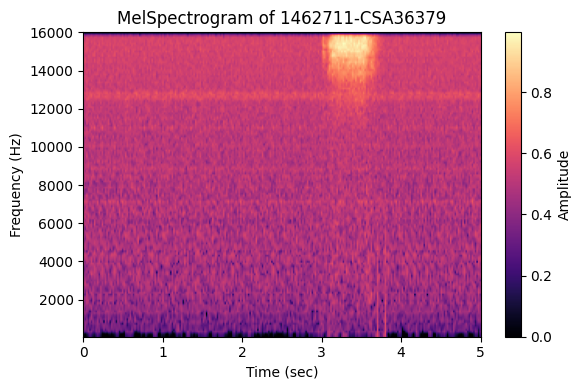

In [268]:
utils_lib.plot_melspectrogram(all_bird_data, "1462711-CSA36379")
utils_lib.play_audio("1462711/CSA36379.ogg", config.train_datadir)

In [233]:
all_bird_data["banana-XC561261"]

array([[0.03839119, 0.        , 0.        , ..., 0.        , 0.        ,
        0.21172382],
       [0.03859528, 0.        , 0.        , ..., 0.        , 0.        ,
        0.21172298],
       [0.03891661, 0.        , 0.        , ..., 0.        , 0.        ,
        0.21172167],
       ...,
       [0.009062  , 0.17803924, 0.17006142, ..., 0.20917383, 0.2642168 ,
        0.26527485],
       [0.00351995, 0.15120627, 0.06605692, ..., 0.08124934, 0.10262968,
        0.10304064],
       [0.        , 0.13416372, 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

以下は関係なし．

In [234]:
spectrograms = np.load("../data/processed/mel_cleaned_0413/birdclef2025_melspec_5sec_256_256.npy", allow_pickle=True).item()


In [235]:
i = 3
idx_list = working_df[working_df["author"] == "Fabio A. Sarria-S"]["primary_label"].unique()
df = working_df[working_df["primary_label"] == f"{idx_list[i]}"][["primary_label", "filename", "author", "valid_end_sec", "duration_sec"]]
df

,primary_label,filename,author,valid_end_sec,duration_sec
37,1462737,1462737/CSA36341.ogg,Fabio A. Sarria-S,7.0,108.290844
38,1462737,1462737/CSA36369.ogg,Fabio A. Sarria-S,7.0,106.155875
39,1462737,1462737/CSA36380.ogg,Fabio A. Sarria-S,7.0,105.365625
40,1462737,1462737/CSA36381.ogg,Fabio A. Sarria-S,7.0,103.985844
41,1462737,1462737/CSA36386.ogg,Fabio A. Sarria-S,7.0,99.418906
42,1462737,1462737/CSA36391.ogg,Fabio A. Sarria-S,7.0,100.744375
43,1462737,1462737/CSA36395.ogg,Fabio A. Sarria-S,7.0,94.085813


In [236]:
utils_lib.play_audio(filename="1462737/CSA36391.ogg",base_path="../data/raw//train_audio/")

In [237]:
# fabioの解説　必ずしも7secではない
# 48124/CSA36346.ogg 24sec以降
# 52884/CSA36344.ogg 55sec以降
# 52884/CSA36342.ogg 14sec以降

In [238]:
i = 19
idx_list = working_df[working_df["collection"] == "CSA"]["primary_label"].unique()
df = working_df[working_df["primary_label"] == f"{idx_list[i]}"][["primary_label", "filename", "author", "valid_end_sec", "duration_sec"]]
df

,primary_label,filename,author,valid_end_sec,duration_sec
911,963335,963335/CSA36372.ogg,Fabio A. Sarria-S,7.0,108.242500
912,963335,963335/CSA36374.ogg,Fabio A. Sarria-S,7.0,103.571344
913,963335,963335/CSA36375.ogg,Fabio A. Sarria-S,7.0,106.700375
914,963335,963335/CSA36377.ogg,Fabio A. Sarria-S,7.0,107.488969
915,963335,963335/CSA36393.ogg,Fabio A. Sarria-S,7.0,97.343281


In [239]:
# CSAチェック
# 最後にスペイン語が含まれていないlabel
# 1564122, 50186/CSA28885.ogg, 523060
# 52884/CSA14875.ogg
# 548639
# 714022
# 868458



# スペイン語最初に含まれる 4secくらい
# 50186/CSA28885.ogg
# 52884/CSA14875.ogg



# 話してる人
# Eliana Barona- Cortés
# Alexandra Butrago-Cardona
# Fabio A. Sarria-S

# 人の声だけの箇所
# 24292/CSA34649.ogg 2min48移行
# 24292/CSA34651.ogg 1min34移行
# 476537/CSA35459.ogg 2min14移行
# 476537/CSA35461.ogg 4min19移行